In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import sub
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


import warnings
warnings.simplefilter("ignore")


In [95]:
df = pd.read_excel('./datasets/default_of_credit_card_clients.xls', header=1)
df = df.drop(df.iloc[:, [0]], axis=1)

In [96]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [97]:
# check to see if there is any missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,LIMIT_BAL,SEX,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,...,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,AGE,MARRIAGE,EDUCATION,default payment next month
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
duplicate = df[df.duplicated()]

print("Duplicate Rows before removal:")
print(duplicate.shape)

# Remove duplicate rows
initial_shape = df.shape[0]
df = df.drop_duplicates()
final_shape = df.shape[0]
duplicates_removed = initial_shape - final_shape

print(f"\nRemoved {duplicates_removed} duplicate rows")
print(f"DataFrame shape: {df.shape}")

Duplicate Rows before removal:
(35, 24)

Removed 35 duplicate rows
DataFrame shape: (29965, 24)


In [99]:
#rename columns
df.rename({'default payment next month': 'DEFAULT'}, axis='columns', inplace=True)
df.rename({'PAY_0': 'PAY_1'}, axis='columns', inplace=True)

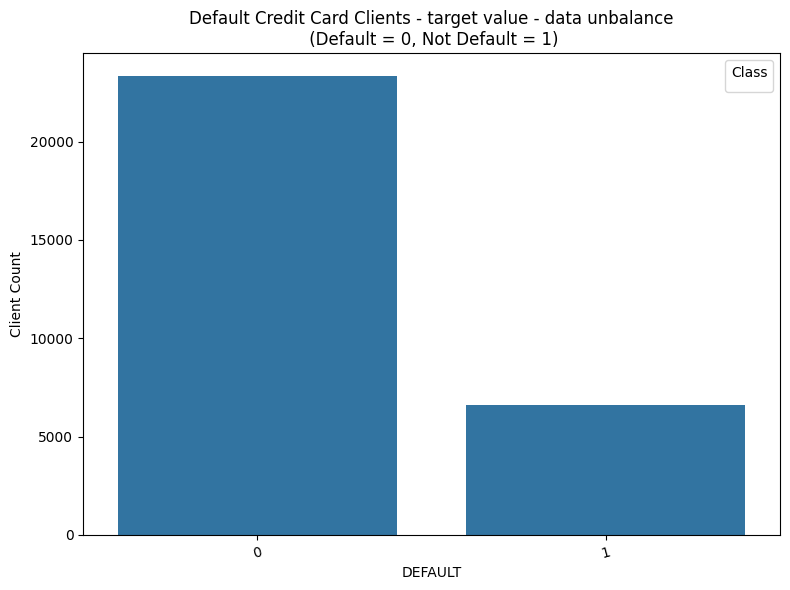

In [100]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='DEFAULT')
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
plt.xlabel('DEFAULT')
plt.ylabel('Client Count')
plt.xticks(rotation=15)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

<!-- A number of 6,636 out of 30,000 (or 22%) of clients will default next month. The data has not a large unbalance with respect of the target value -->

In [101]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

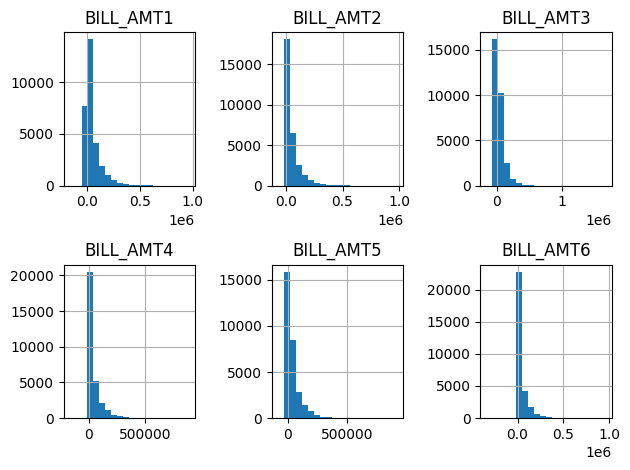

In [102]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 2, 3, 20)

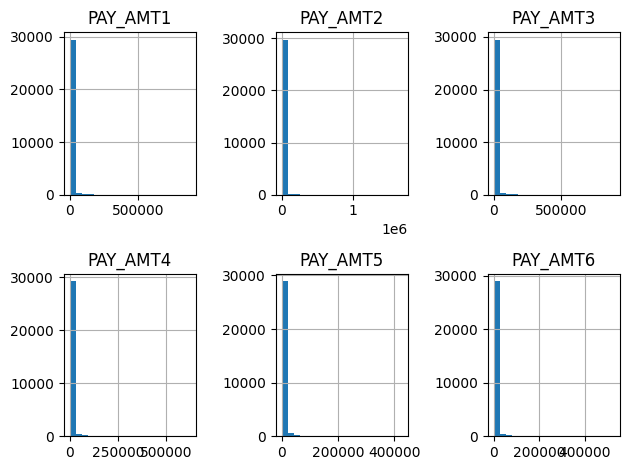

In [103]:
pay = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
draw_histograms(pay, pay.columns, 2, 3, 20)

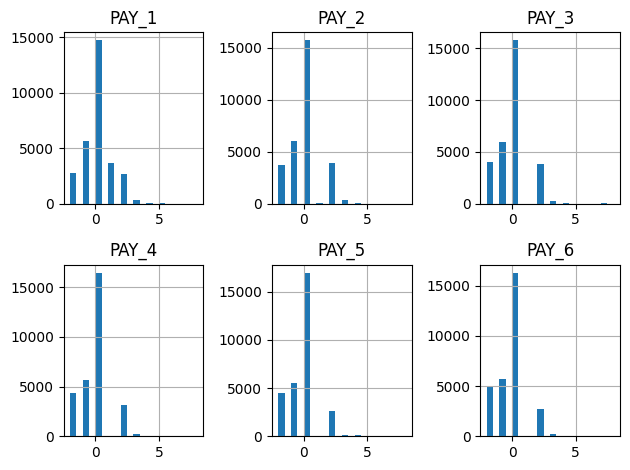

In [104]:
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 20)

<Axes: >

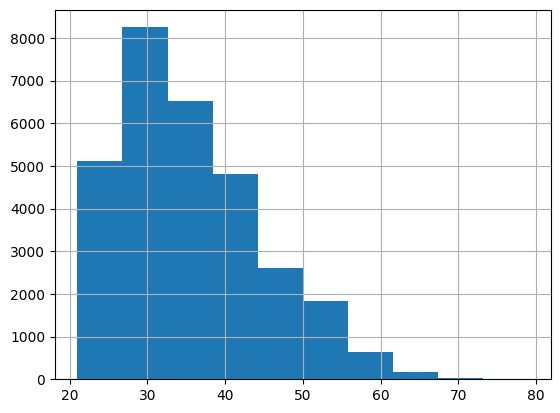

In [105]:
df.AGE.hist()

<Axes: >

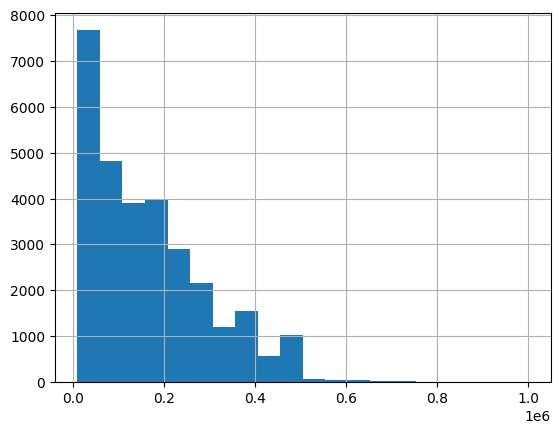

In [106]:
df.LIMIT_BAL.hist(bins = 20)

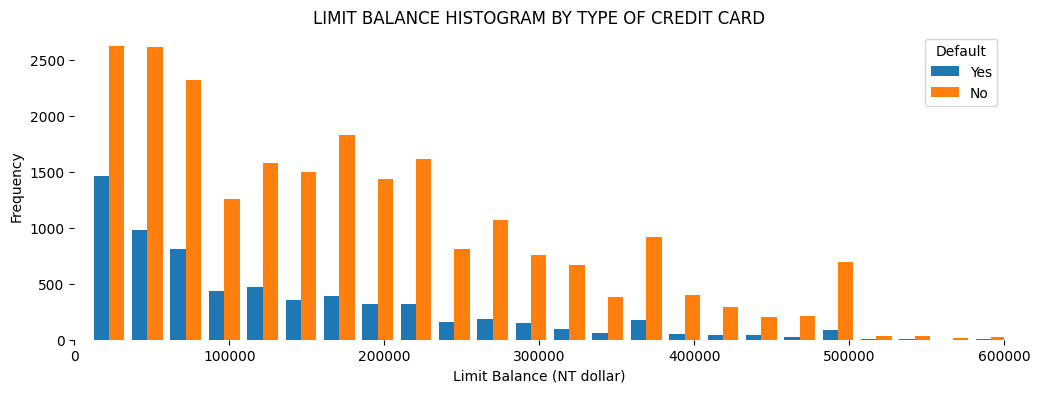

In [107]:
x1 = list(df[df['DEFAULT'] == 1]['LIMIT_BAL'])
x2 = list(df[df['DEFAULT'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(12,4))
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins=40)
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('LIMIT BALANCE HISTOGRAM BY TYPE OF CREDIT CARD')
plt.box(False)

<!-- There are 30,000 credit card clients.

The average value for the amount of credit card limit is 167,484 NT dollars. The standard deviation is 129,747 NT dollars, ranging from 10,000 to 1M NT dollars.

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

Average age is 35.5 years, with a standard deviation of 9.2.

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis). -->

<!-- DATA CLEANING
As seen previously, some categories are mislabeled or undocumented. Before proceeding, it is time to fix it.
No missing data, but a few anomalous things:

EDUCATION has category 5 and 6 that are unlabelled, moreover the category 0 is undocumented.
MARRIAGE has a label 0 that is undocumented
Reffering to the PAY_1 ... PAY_6
They all present an undocumented label -2. If 1,2,3, etc are the months of delay, 0 should be labeled 'pay duly' and every negative value should be seen as a 0. But we will get to that later


According to our documentation, the PAY_n variables indicate the number of months of delay and indicates "pay duly"with -1. Then what is -2? And what is 0? It seems to me the label has to be adjusted to 0 for pay duly -->

In [108]:
#verify unique values for some categorical features
print("Unique values for features: \n",
       "Gender: ", df["SEX"].unique(), "\n",
       df["SEX"].value_counts(), "\n",   
       "Education: ", df["EDUCATION"].unique(), "\n",
              df["EDUCATION"].value_counts(), "\n"
       "MARRIAGE: " , df["MARRIAGE"].unique(), "\n", 
              df["MARRIAGE"].value_counts(), "\n"
)

Unique values for features: 
 Gender:  [2 1] 
 SEX
2    18091
1    11874
Name: count, dtype: int64 
 Education:  [2 1 3 5 4 6 0] 
 EDUCATION
2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: count, dtype: int64 
MARRIAGE:  [1 2 3 0] 
 MARRIAGE
2    15945
1    13643
3      323
0       54
Name: count, dtype: int64 



In [109]:
len(df.loc[(df.EDUCATION == 0) |  (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.MARRIAGE == 0)])

399

In [110]:
df = df.loc[(df.EDUCATION != 0)  & (df.EDUCATION != 5) & (df.EDUCATION != 6) & (df.MARRIAGE != 0)]
df.shape

(29566, 24)

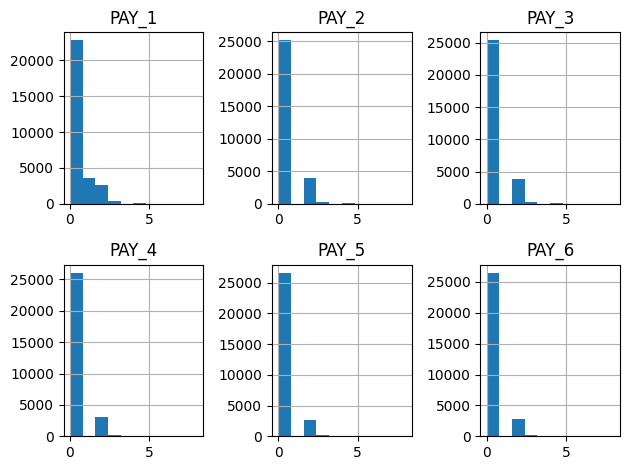

In [111]:
fil = (df.PAY_1 == -2) | (df.PAY_1 == -1) | (df.PAY_1 == 0)
df.loc[fil, 'PAY_1'] = 0
fil = (df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0)
df.loc[fil, 'PAY_2'] = 0
fil = (df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0)
df.loc[fil, 'PAY_3'] = 0
fil = (df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0)
df.loc[fil, 'PAY_4'] = 0
fil = (df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0)
df.loc[fil, 'PAY_5'] = 0
fil = (df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0)
df.loc[fil, 'PAY_6'] = 0
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10)

In [112]:
df_no_default = df[df['DEFAULT']==0]
df_default = df[df['DEFAULT']==1]
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=3000, random_state=42)
df_default_downsampled = resample(df_default, replace=False, n_samples=3000, random_state=42 )
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
df_downsample.shape


(6000, 24)

In [113]:
#split the data into inputs and target
X = df.drop("DEFAULT", axis=1).copy()
y = df["DEFAULT"].copy()

In [114]:
X.shape

(29566, 23)

In [115]:
X_encoded = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_5_8,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,False,False,True,False,False,False,False,False,False,False
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,False,False,False,True,False,False,False,False,False,False
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,False,False,True,False,False,False,False,False,False,False
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,False,False,True,False,False,False,False,False,False,False
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,False,False,True,False,False,False,False,False,False,False


In [116]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2)

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test
X_train_scaled = X_train

In [118]:
clf_svm = SVC(probability=True, random_state=42, 
        kernel='rbf', C=10.0, gamma='scale', decision_function_shape="ovr")
# Train the model on the full training set for final predictions
clf_svm.fit(X_train_scaled, y_train)

,C,10.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [119]:
y_pred = clf_svm.predict(X_test_scaled)

Accuracy:  0.8192424754819073
Recall:  0.6666666666666666
Precision:  0.3515805705474171
F1 Score:  0.4603735487127713


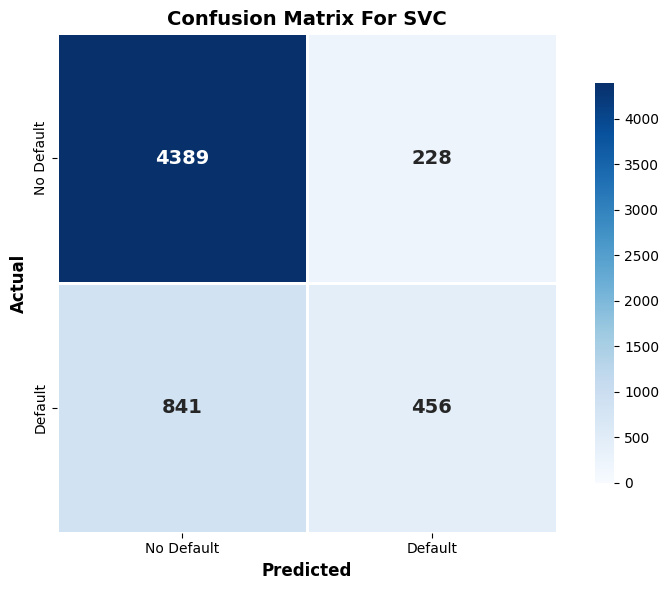

In [124]:
#display and visualize scores and the confusion matrix

print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ', recall_score(y_pred, y_test))
print('Precision: ', precision_score(y_pred, y_test))
print('F1 Score: ', f1_score(y_pred, y_test))

# Convert numeric labels to string labels for visualization
label_mapping = {0: 'No Default', 1: 'Default'}
y_test_labels = [label_mapping[int(val)] for val in y_test]
y_pred_labels = [label_mapping[int(pred)] for pred in y_pred]

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=['No Default', 'Default'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            vmin=0, vmax=None, square=True, linewidths=2, 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'],
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 14, "weight": "bold"})
plt.title("Confusion Matrix For SVC", fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

They all present an undocumented label -2. If 1,2,3, etc are the months of delay, 0 should be labeled 'pay duly' and every negative value should be seen as a 0. But we will get to that later

What I observe is that the quantities referred to some amount of money have a very large range, which can cause problems to some some models (for example in linear regression models)

Data Cleaning¶
As seen previously, some categories are mislabeled or undocumented. Before proceeding, it is time to fix it.

The 0 in MARRIAGE can be safely categorized as 'Other' (thus 3).

The 0 (undocumented), 5 and 6 (label unknown) in EDUCATION can also be put in a 'Other' cathegory (thus 4)

According to our documentation, the PAY_n variables indicate the number of months of delay and indicates "pay duly"with -1. Then what is -2? And what is 0? It seems to me the label has to be adjusted to 0 for pay duly.

In [121]:
# perm_importance = permutation_importance(clf_svm, X_test_scaled, y_test)

# feature_names = list(X.columns.values)
# features = np.array(feature_names)

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")


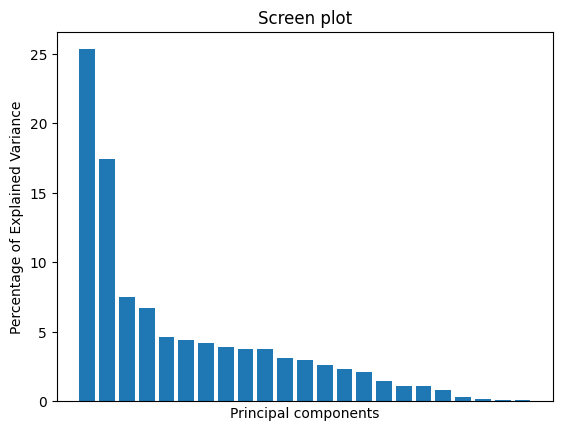

In [122]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_scaled)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Percentage of Explained Variance')    
plt.xlabel('Principal components')
plt.title('Screen plot')
plt.show()



# # Create a new scaler specifically for PCA coordinates (fit on training data only)

In [123]:
# train_pc1_coords = X_train_pca[:, 0]
# train_pc2_coords = X_train_pca[:, 1]

# pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# clf_svm = SVC(random_state=42, C=10, gamma=0.01)
# clf_svm.fit(pca_train_scaled, y_train)

# X_test_pca = pca.transform(X_test_scaled)

# # Step 2: Extract PC1 and PC2 from test data
# test_pc1_coords = X_test_pca[:, 0]
# test_pc2_coords = X_test_pca[:, 1]

# # Step 3: Scale test PC coordinates using the same scaler fitted on training data
# pca_test_scaled = scale(np.column_stack((test_pc1_coords, test_pc2_coords)))

# # Step 4: Make predictions on the PCA-transformed test data
# y_pred_pca = clf_svm.predict(pca_test_scaled)

# # Step 5: Evaluate the model
# print('Accuracy with PCA: ', accuracy_score(y_test, y_pred_pca))
# print('Recall with PCA: ', recall_score(y_test, y_pred_pca))
# print('Precision with PCA: ', precision_score(y_test, y_pred_pca))
# print('F1 Score with PCA: ', f1_score(y_test, y_pred_pca))

# # Step 6: Display confusion matrix
# conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)
# sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap="viridis")
# plt.title("Confusion Matrix For SVC with PCA", fontsize=14)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()